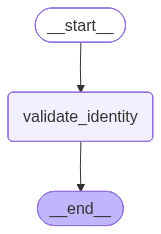

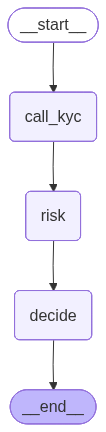

KYC: PASS
Risk score: 20
Decision: APPROVE ✅


In [1]:
from langgraph.graph import StateGraph
from typing import TypedDict, Literal
from IPython.display import Image, display

# -----------------------------
# Graph 1: KYC Graph (sub-graph)
# -----------------------------
class KYCState(TypedDict):
    name: str
    pan: str
    kyc_status: Literal["PENDING", "PASS", "FAIL"]

def kyc_validate_identity(state: KYCState) -> KYCState:
    # toy rules: name must exist + PAN must be 10 chars
    if state["name"].strip() and len(state["pan"]) == 10:
        state["kyc_status"] = "PASS"
    else:
        state["kyc_status"] = "FAIL"
    return state

kyc_builder = StateGraph(KYCState)
kyc_builder.add_node("validate_identity", kyc_validate_identity)
kyc_builder.set_entry_point("validate_identity")
kyc_builder.set_finish_point("validate_identity")
kyc_graph = kyc_builder.compile()

# Draw KYC graph
display(Image(kyc_graph.get_graph().draw_mermaid_png()))


# -----------------------------------
# Graph 2: Loan Approval Graph (parent)
# -----------------------------------
class LoanState(TypedDict):
    name: str
    pan: str
    income: int
    kyc_status: Literal["PENDING", "PASS", "FAIL"]
    risk_score: int
    decision: str

def compute_risk(state: LoanState) -> LoanState:
    # toy risk: higher income -> lower risk score
    state["risk_score"] = 20 if state["income"] >= 50000 else 80
    return state

def call_kyc_subgraph(state: LoanState) -> LoanState:
    # ✅ EXCHANGE happens here: parent -> child input
    kyc_input: KYCState = {
        "name": state["name"],
        "pan": state["pan"],
        "kyc_status": "PENDING"
    }

    # Run KYC graph
    kyc_result = kyc_graph.invoke(kyc_input)

    # ✅ EXCHANGE back: child output -> parent state merge
    state["kyc_status"] = kyc_result["kyc_status"]
    return state

def decide(state: LoanState) -> LoanState:
    if state["kyc_status"] == "FAIL":
        state["decision"] = "REJECT (KYC failed)"
    elif state["risk_score"] < 50:
        state["decision"] = "APPROVE ✅"
    else:
        state["decision"] = "MANUAL REVIEW 🕵️"
    return state

loan_builder = StateGraph(LoanState)
loan_builder.add_node("call_kyc", call_kyc_subgraph)
loan_builder.add_node("risk", compute_risk)
loan_builder.add_node("decide", decide)

loan_builder.set_entry_point("call_kyc")
loan_builder.add_edge("call_kyc", "risk")
loan_builder.add_edge("risk", "decide")
loan_builder.set_finish_point("decide")
loan_graph = loan_builder.compile()

# Draw Loan graph
display(Image(loan_graph.get_graph().draw_mermaid_png()))


# -----------------------------
# Run parent graph
# -----------------------------
initial_state: LoanState = {
    "name": "Madhu",
    "pan": "ABCDE1234F",   # 10 chars -> PASS
    "income": 65000,
    "kyc_status": "PENDING",
    "risk_score": 0,
    "decision": ""
}

result = loan_graph.invoke(initial_state)
print("KYC:", result["kyc_status"])
print("Risk score:", result["risk_score"])
print("Decision:", result["decision"])
